This problem compares two sampling methods for constructing samples from a posterior distribution.  We observe samples from a multinomial distribution,

$$(Y_1, Y_2, Y_3, Y_t) \sim \mathcal{M} \left( n ; \frac{1}{2}+ \frac{\theta}{4}, \frac{1}{4} (1 - \theta), \frac{1}{4} (1 - \theta), \theta/4 \right)$$.

The prior distribution of $\theta$ is the uniform distribution on the interval $(0, 1)$.  The log-posterior distribution is proportional to 

$$ \log \pi ( \theta \vert Y ) \propto Y_1 \log(2 + \theta) + (Y_2 + Y_3 ) \log(1- \theta) + Y_4 \log \theta$$

We have first implemented a rejection sampler.  In the next block we first sample $Y$ from the multinomial distribution with $\theta_* = 0.2$ and $n=20$ and then sample from the posterior distribution.  We report the sample mean and plot the histogram of samples.

The sampled Y values are: [ 9  5 13  3]
Max time reached. 77 samples were generated.
Inner while loop iterations: 1019923
The sample mean is: 0.2014


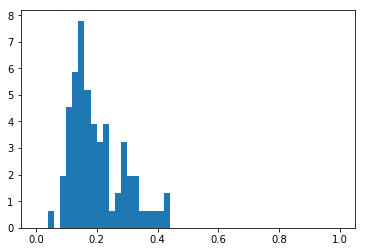

In [5]:
import numpy as np
import sampling
import matplotlib.pyplot as plt
import imp
imp.reload(sampling)

n = 30
thetastar=0.2
prob = np.array([1/2+thetastar/4, 1/4*(1-thetastar), 1/4*(1-thetastar), thetastar/4])

Y = np.random.multinomial(n, prob)
print('The sampled Y values are:', Y)


#sampling.rej_samples takes three arguments.  The multinomial sampling, and 
#then a maximum number of samples to generate, or a maximum time to run.  
#The sampler terminates whichever comes first.

X = sampling.rej_samples(Y, maxsamp=100000,maxtime=30)

print('The sample mean is:', "{0:.4f}".format(np.mean(X)))

plt.hist(X, 50, range=[0, 1], density=True)
plt.show()




We also can compare the sampler with the mode of the distribution:

In [6]:
xx = np.arange(0.001,0.999,0.001)
mod = xx[np.argmax(sampling.logpx(Y,xx))]
print('The mode of the distribution is approximately:', mod)

The mode of the distribution is approximately: 0.171


We have also implemented an importance sampler.  It can take a maximum number of iterations to reach as well as a time limit over which to run.  The default is to not have a maximum number of iterations, as this does not have much to do with the effective sample size.

The sampler returns samples and weights $(x_i, w_i)$.  There is an additional post-processing step attempting to avoid numerical overflow in the weights.  The effective sample size is
$$
ESS = \frac{1}{\sum_i w_i^2 }
$$

In [8]:
imp.reload(sampling)
[th,w] = sampling.imp_samples(Y,maxtime=30)
print('The sample mean is:', "{0:.4f}".format(np.dot(th,w)))

120414 samples were generated with an ESS of 35378.60
Additional post-processing time: 0.0030 seconds
The sample mean is: 0.2012


In the following experiment we increase $n$ and compare the number of samples generated by rejection sampling to the effective sampling size of importance sampling.  Each sampler is given equal computation time.

We remark that as we increase $n$ we have chosen to couple the multinomial samples together in order to get smoother behavior.

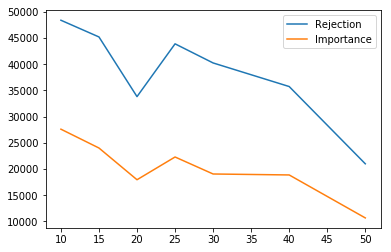

In [9]:
imp.reload(sampling)
nvals = [10, 15, 20, 25, 30, 40, 50]
comptime = 8
nrej = np.array([])
nimp = np.array([])
for i in range(0,len(nvals)):
    if i == 0:
        YY = np.random.multinomial(nvals[i], prob)
    else:
        YY = YY + np.random.multinomial(nvals[i]-nvals[i-1], prob)
    nrej = np.append(nrej,sampling.rej_samples(YY,maxtime=comptime, verbose = False).size)
    [th,w]= sampling.imp_samples(YY, maxtime=comptime, verbose = False)
    nimp=np.append(nimp, np.power(np.linalg.norm(w), -2))
    
plt.plot(nvals,nrej)
plt.plot(nvals,nimp)
plt.legend(['Rejection', 'Importance' ], loc='upper right')

plt.show()


In the following we compare the variances of the estimator of the mean produced by both sampling methods.

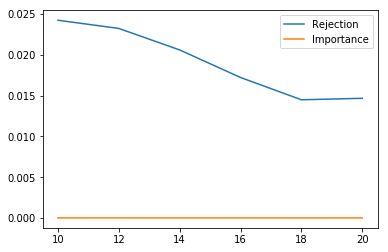

In [54]:
nrepeats = 10
comptime = 0.5
nvals = [10, 12, 14, 16, 18, 20]
varrej = np.array([])
varimp = np.array([])
for i in range(0, len(nvals)):
    if i == 0:
        YY = np.random.multinomial(nvals[i], prob)
    else:
        YY = YY + np.random.multinomial(nvals[i]-nvals[i-1], prob)
    xrej = np.array([])
    ximp = np.array([])
    for j in range(0, nrepeats):
        xrej = np.append(xrej,sampling.rej_samples(YY,maxtime=comptime, verbose = False))
        [th, w]=sampling.imp_samples(YY, maxtime=comptime, verbose = False)
        ximp = np.append(ximp,np.dot(w,th))
    varrej = np.append(varrej,np.var(xrej))
    varimp = np.append(varimp,np.var(ximp))
    
plt.plot(nvals,varrej)
plt.plot(nvals,varimp)
plt.legend(['Rejection', 'Importance' ], loc='upper right')
plt.show()
    
    
    

In the following, we compare the behavior of importance sampling using two different proposal distributions.  Above, the proposal distribution was the uniform distribution on $(0, 1)$.  By Bernstein-von Mises theorem we know that the asymptotic distribution of the posterior is a normal distribution centered at the MLE $\hat{\theta}$ with a variance that may be approximated by
$$
var \sim \frac{-1}{  \partial_\theta^2 \log p (Y | \hat{ \theta} ) }
$$
We therefore choose as a proposal distribution a normal centered at the MLE with the above variance, conditioned to fall in $(0, 1)$.

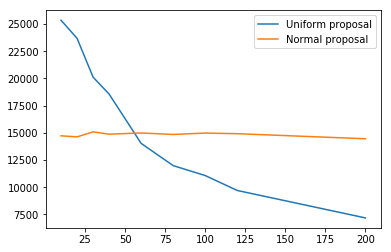

In [11]:
nvals = [10, 20, 30, 40, 60, 80, 100, 120, 200]
comptime = 3
nimp = np.array([])
nnor = np.array([])

for i in range(0, len(nvals)):
    if i == 0:
        YY = np.random.multinomial(nvals[i], prob)
    else:
        YY = YY + np.random.multinomial(nvals[i]-nvals[i-1], prob)
    [th,w]= sampling.imp_samples(YY, maxtime=comptime, verbose = False)
    nimp=np.append(nimp, np.power(np.linalg.norm(w), -2))
    [th,w]= sampling.imp_samples_normal(YY, maxtime=comptime, verbose = False)
    nnor=np.append(nnor, np.power(np.linalg.norm(w), -2))
    
    
plt.plot(nvals,nimp)
plt.plot(nvals,nnor)
plt.legend(['Uniform proposal', 'Normal proposal' ], loc='upper right')

plt.show()